In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets


torch.manual_seed(13)

# SoftMax Classifier

## Data

MNIST Dataset

In [ ]:
train_dataset = dsets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dsets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())


1654784it [00:20, 662594.31it/s]                             

In [4]:
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train


In [3]:
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test


In [ ]:
from torch.utils.data import Dataset, DataLoader


# Data
train_dataloader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

## Model
$\newcommand{\vecx}{{\bf x}}$
$\newcommand{\vecb}{{\bf b}}$
$\newcommand{\vecy}{{\bf y}}$

Given training dataset $X^l = \{ (\vecx_i, \vecy_i) \}^{l}_{i=1}$, where $\vecx_i \in \mathbb{R}^{n}$ and $\vecy_i \in \{1,2,\ldots, C\}$, i.e. supervised multi-class classification.

We will find solution in the following form

$$ \hat{\vecy} = softmax \left( \vecx \cdot W + \vecb \right) $$

As loss function we will use Cross Entropy Loss:

$$ L(\hat{\vecy}, \vecy) = \sum\limits_{i=1}^{C} y_i \log \hat{y}_i , $$

where $\vecy$ is one-hot vector with only one non-zero coordinate. Therefore total loss is $\mathcal{L} = -\frac{1}{l} \sum L(\hat{\vecy}, \vecy) $.

In [6]:
import torch.nn as nn


class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z

In [9]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Training

As before we are going to use SGD to train our Model. 

Note that we don't need to apply $softmax$ in `forward` function since loss function `torch.nn.CrossEntropyLoss` takes unnormalized weights as input and applys $softmax$.

In [31]:
def train(train_dataloader, validation_loader, model, loss_f, optimizer, num_epoch=10):
    N_test = len(validation_loader)

    # Training Loop
    losses = []
    accuracy = []
    for epoch in range(num_epoch):
        total_loss = 0
        for x, y in train_dataloader:
            y_hat = model(x.view(-1, 28 * 28))
            loss = loss_f(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)

        correct = 0
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        accuracy.append(correct / N_test)
    return losses, accuracy

In [ ]:
from torch.nn import CrossEntropyLoss


# Model
model = SoftMax(28 * 28, 10)

# Loss
loss_f = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

losses, accuracy = train(train_dataloader, validation_loader, model, loss_f, optimizer, num_epoch=10)

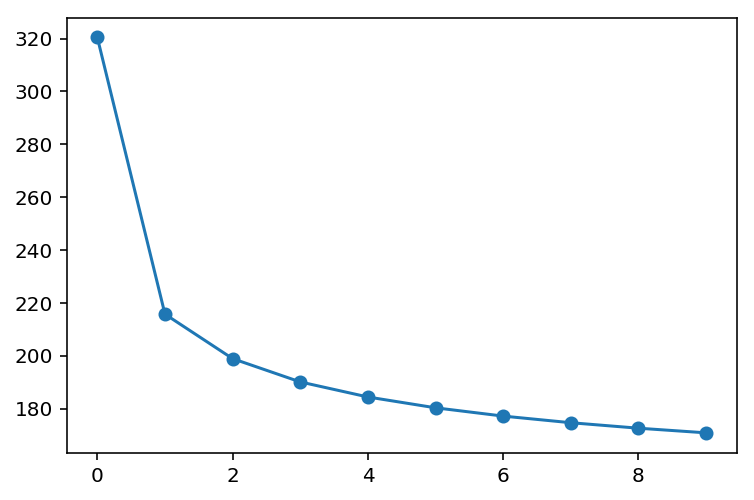

In [23]:
plt.plot(losses, marker='o')

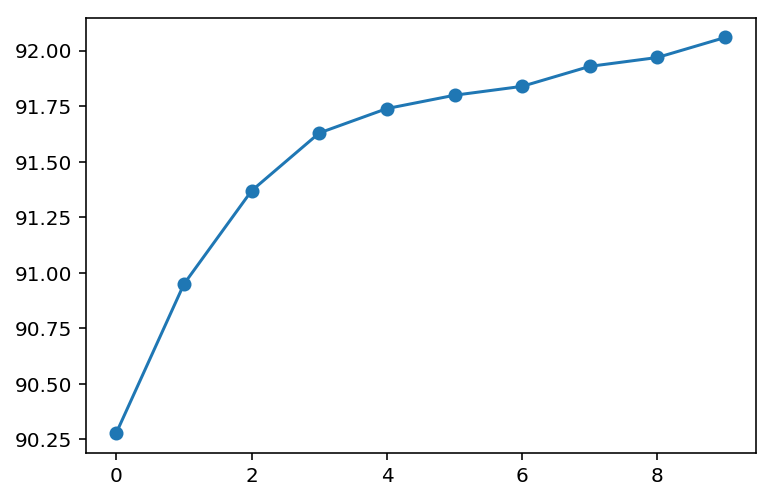

In [24]:
plt.plot(accuracy, marker='o')

# Simple Neural Network

## HardWay

Valid but not very pretty

In [25]:
class Net(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Net, self).__init__()
        
        self.layer1 = nn.Linear(in_dim, h_dim)
        self.layer2 = nn.Linear(h_dim, out_dim)
        
    def forward(self, x):
        h = torch.sigmoid(self.layer1(x))
        out = torch.sigmoid(self.layer2(h))
        return out

## NiceWay

Using `nn.Sequential`. Note that `ReLU` activation function leads to better performance than `Sigmoid` because of the vanishing-gradients problem. 

In [35]:
class Net(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, out_dim),
#             nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    

model = Net(1, 2, 1)
model(torch.tensor([1.]))

tensor([0.7694], grad_fn=<AddBackward0>)

In [36]:
from torch.nn import CrossEntropyLoss


# Model
model = Net(28 * 28, 100, 10)

# Loss
loss_f = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

losses, accuracy = train(train_dataloader, validation_loader, model, loss_f, optimizer, num_epoch=15)

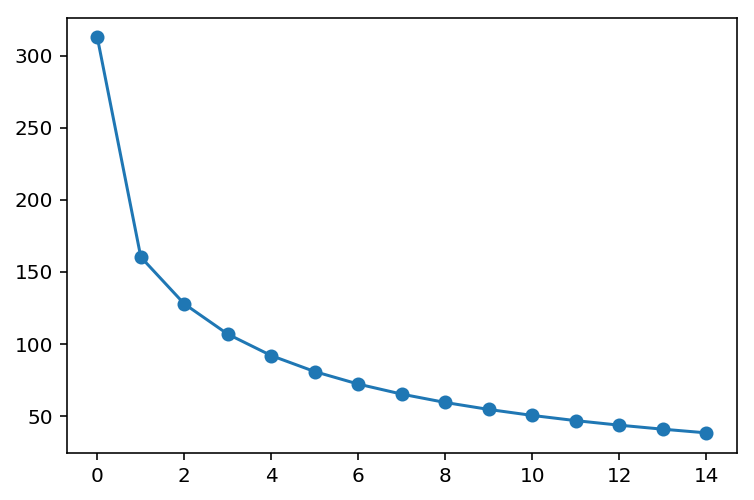

In [37]:
plt.plot(losses, marker='o')

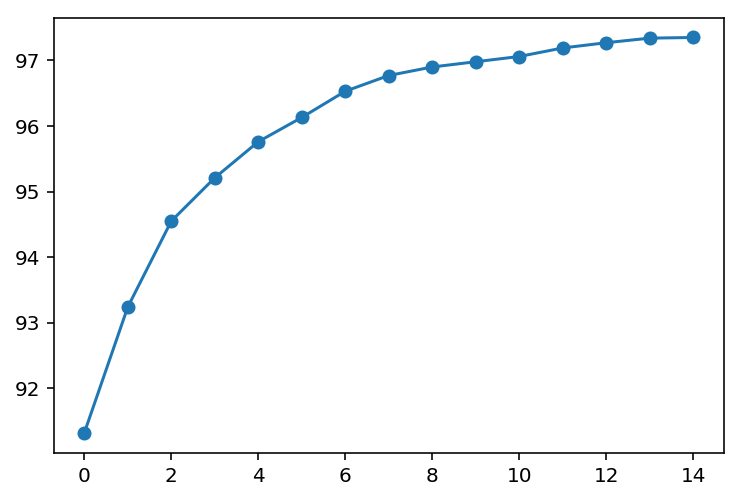

In [38]:
plt.plot(accuracy, marker='o')